In [1]:
%pip install pandas matplotlib numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
human_ratings = {
    'Story': ['American Story Old Phoebe', 'American Story Birthday', 'American Story Flying', 'American Story Lottery', 'American Story Ylla'],
    'Suspense': [3.4, 3.2, 3.6, 4.5, 5.1],

}
#'Curiosity Past': [2.1, 3.2, 3.5, 3.9, 4.2],
    #'Curiosity Future': [4.0, 3.8, 3.8, 5.0, 5.2],
    #'Surprise': [2.8, 3.1, 3.5, 3.2, 4.1],
    #'Irony': [2.4, 2.8, 3.1, 2.7, 3.6]

In [4]:
import ast
import os
import pandas as pd
import json

def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, float]:
    llm_ratings = {}

    all_ratings = {}
    
    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path, header=None, names=['experiment_name', 'version', 'response'])
                    
                    for index, row in df.iterrows():
                        if 'Chunks' in row['version']:
                            story_name = row['version'].split(' Chunks')[0]
                            
                            response = row["response"]
                            try:
                                response_dict = json.loads(response.replace("'", "\"")) 
                            except json.JSONDecodeError:
                                try:
                                    response_dict = ast.literal_eval(response)
                                except (ValueError, SyntaxError):
                                    print(f"Skipping malformed response: {response}")
                                    continue
                            if None in response_dict.values():
                                print(f"Skipping story '{story_name}' due to None value in response")
                                continue
                            value = [value for value in response_dict.values()]
                            average_value = sum(value) / len(value) if value else 0

                            if story_name not in all_ratings:
                                all_ratings[story_name] = []
                            all_ratings[story_name].append(average_value)
    
    for story, values in all_ratings.items():
        print(story, value)
        llm_ratings[story] = sum(values) / len(values) if values else 0 

    return llm_ratings




In [5]:
llm_rating_sources = ['brewer_experiment/creative'] 
llm_ratings = get_llm_ratings(llm_rating_sources)

print(llm_ratings)

American Story Old Phoebe [4, 3, 2, 2, 2]
American Story Lottery [4, 3, 2, 2, 2]
American Story Ylla [4, 3, 2, 2, 2]
American Story Flying [4, 3, 2, 2, 2]
American Story Birthday [4, 3, 2, 2, 2]
{'American Story Old Phoebe': 2.1666666666666665, 'American Story Lottery': 3.466666666666667, 'American Story Ylla': 5.333333333333333, 'American Story Flying': 3.733333333333334, 'American Story Birthday': 3.233333333333334}


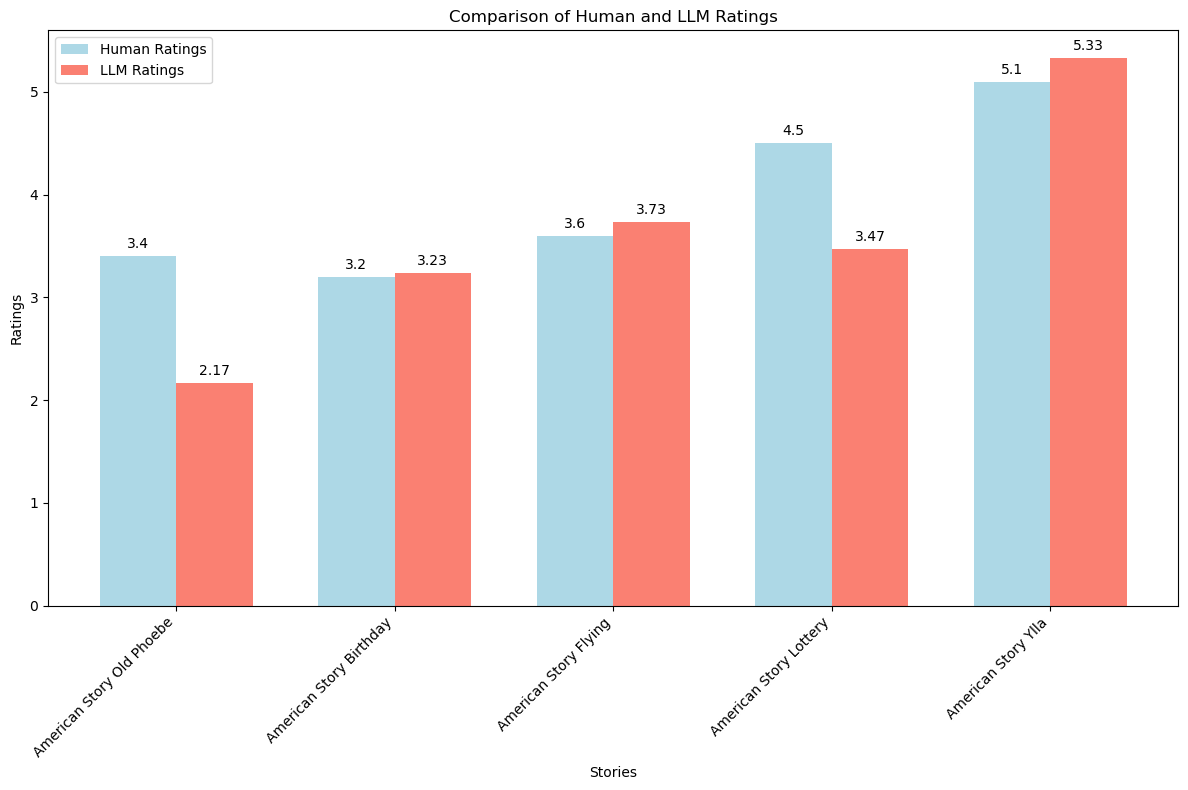

In [6]:
df_human = pd.DataFrame(human_ratings)
df_llm = pd.DataFrame(list(llm_ratings.items()), columns=['Story', 'LLM'])

df_combined = pd.merge(df_human, df_llm, on='Story')

fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(df_combined['Story']))
bar_width = 0.35

bars_human = ax.bar(index - bar_width / 2, df_combined['Suspense'], bar_width, label='Human Ratings', color='lightblue')

bars_llm = ax.bar(index + bar_width / 2, df_combined['LLM'], bar_width, label='LLM Ratings', color='salmon')

for bar in bars_human:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

for bar in bars_llm:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

ax.set_xlabel('Stories')
ax.set_ylabel('Ratings')
ax.set_title('Comparison of Human and LLM Ratings')
ax.set_xticks(index)
ax.set_xticklabels(df_combined['Story'], rotation=45, ha='right', fontsize=10)
ax.legend()

plt.tight_layout()
plt.show()